Nutrient comparisons with edited dataset using surface instead of 2m for depth.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import pytz
%matplotlib inline

In [47]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
nutrients_2015 = pd.read_excel('/home/vdo/Downloads/PSFbottledata_CN_edits.xlsx')

In [4]:
nowcast = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02')

In [5]:
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')

In [6]:
datetimes = np.array([datetime.datetime.combine(pd.to_datetime(nutrients_2015['date'][index]),
                                      nutrients_2015['Time'][index]) 
                      for index in nutrients_2015.index])

In [7]:
nutrients_2015 = nutrients_2015.assign(datetime = datetimes)

In [8]:
local = pytz.timezone ("America/Los_Angeles")

In [9]:
utc_datetimes = np.array([local.localize(nutrients_2015['datetime'][index], 
                                         is_dst=None).astimezone(pytz.utc)
                          for index in nutrients_2015.index])

In [10]:
nutrients_2015 = nutrients_2015.assign(utc_datetime = utc_datetimes)

In [11]:
nowcast_si = nowcast.silicon
nowcast_nitrate = nowcast.nitrate

In [12]:
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)

In [13]:
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)

In [20]:
nutrients_2015 = nutrients_2015.dropna(axis ='index', how = 'any')

In [46]:
nutrients_2015[:5]

,station,num,depth,date,Time,lat,lon,no23,si,po4,datetime,utc_datetime,Yind,Xind
12,CBC1,164,0,2015-04-02,10:29:00,48.740000,-123.606667,7.70,99.79,0.629,2015-04-02 10:29:00,2015-04-02 17:29:00+00:00,378.0,203.0
13,CBC1,166,20,2015-04-02,10:29:00,48.740000,-123.606667,21.66,40.24,1.985,2015-04-02 10:29:00,2015-04-02 17:29:00+00:00,378.0,203.0
14,CBC2,176,0,2015-04-02,10:59:00,48.748333,-123.605000,5.65,82.72,0.474,2015-04-02 10:59:00,2015-04-02 17:59:00+00:00,380.0,204.0
15,CBC2,178,20,2015-04-02,10:59:00,48.748333,-123.605000,22.25,42.60,1.922,2015-04-02 10:59:00,2015-04-02 17:59:00+00:00,380.0,204.0
16,CBE2,168,0,2015-04-02,09:30:00,48.736667,-123.571667,11.43,64.98,0.987,2015-04-02 09:30:00,2015-04-02 16:30:00+00:00,375.0,207.0


In [22]:
list_of_model_si = np.array([])
list_of_model_ni = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    date = pd.to_datetime(nutrients_2015['utc_datetime'][n])
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        delta = (date.minute + 30) / 60
        si_val = (delta * ((nowcast_si
               .sel(time = before, depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_si
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        ni_val = (delta * ((nowcast_nitrate
               .sel(time = before, depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_nitrate
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        delta = date.minute/60
        si_val = (delta * ((nowcast_si
               .sel(time = before, depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_si
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
        ni_val = (delta * ((nowcast_nitrate
               .sel(time = before, depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values) + 
               (1- delta)*((nowcast_nitrate
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = nutrients_2015['depth'][n], method = 'nearest')
               .isel(gridY = Yind, gridX = Xind)).values))
    list_of_model_si = np.append(list_of_model_si, si_val)
    list_of_model_ni = np.append(list_of_model_ni, ni_val)

bias =  -1.92252287534
RMSE = 7.14948708621
Willmott = 0.843879901001


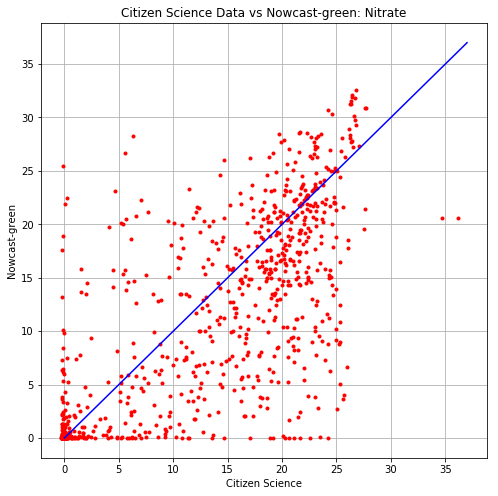

In [23]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(nutrients_2015['no23'].values, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(nutrients_2015['no23'].values) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - nutrients_2015['no23'].values)**2) /
                              len(list_of_model_ni))))
xbar = np.mean(nutrients_2015['no23'].values)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - nutrients_2015['no23'].values)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(nutrients_2015['no23'].values - xbar))**2))))

bias =  -10.546421996
RMSE = 17.5269880061
Willmott = 0.7020766250305208


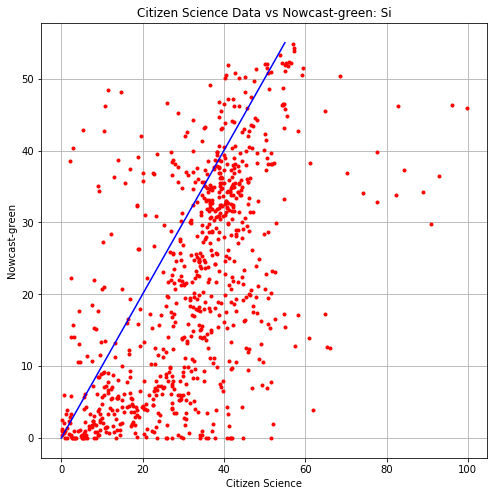

In [24]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(nutrients_2015['si'].values, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(nutrients_2015['si']) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - nutrients_2015['si'])**2) /
                              len(list_of_model_si))))
xbar = np.mean(nutrients_2015['si'])
print('Willmott = ' + str(1-(np.sum((list_of_model_si - nutrients_2015['si'])**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(nutrients_2015['si'] - xbar))**2))))

In [25]:
surface_si_model = np.array([])
surface_ni_model = np.array([])
deeper_si_model = np.array([])
deeper_ni_model = np.array([])
surface_si_cs = np.array([])
surface_ni_cs = np.array([])
deeper_si_cs = np.array([])
deeper_ni_cs = np.array([])
deeper_lats = np.array([])
surface_lats = np.array([])
deeper_times = np.array([])
surface_times = np.array([])
c = 0
for n in nutrients_2015.index:
    if nutrients_2015['depth'][n] == 20:
        deeper_si_model = np.append(deeper_si_model, list_of_model_si[c])
        deeper_si_cs = np.append(deeper_si_cs, nutrients_2015['si'][n])
        deeper_ni_model = np.append(deeper_ni_model, list_of_model_ni[c])
        deeper_ni_cs = np.append(deeper_ni_cs, nutrients_2015['no23'][n])
        deeper_lats = np.append(deeper_lats, nutrients_2015['lat'][n])
        deeper_times = np.append(deeper_times, nutrients_2015['utc_datetime'][n])
    if nutrients_2015['depth'][n] < 5:
        surface_si_model = np.append(surface_si_model, list_of_model_si[c])
        surface_si_cs = np.append(surface_si_cs, nutrients_2015['si'][n])
        surface_ni_model = np.append(surface_ni_model, list_of_model_ni[c])
        surface_ni_cs = np.append(surface_ni_cs, nutrients_2015['no23'][n])
        surface_lats = np.append(surface_lats, nutrients_2015['lat'][n])
        surface_times = np.append(surface_times, nutrients_2015['utc_datetime'][n])
    c = c + 1

In [26]:
deeper_lons = np.array([])
surface_lons = np.array([])
for n in nutrients_2015.index:
    if nutrients_2015['depth'][n] == 20:
        deeper_lons = np.append(deeper_lons, nutrients_2015['lon'][n])
    if nutrients_2015['depth'][n] < 5:
        surface_lons = np.append(surface_lons, nutrients_2015['lon'][n])

bias =  -0.810381877723
RMSE = 6.42272941454
Willmott = 0.84501856767


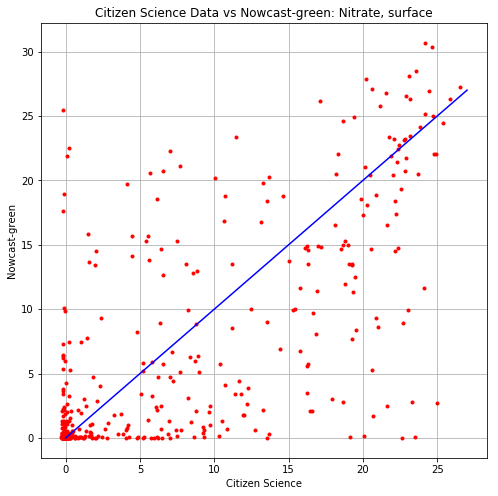

In [31]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_ni_cs, surface_ni_model, 'r.')
ax.plot(np.arange(0,28), np.arange(0,28), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate, surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_ni_cs) + np.mean(surface_ni_model)))
print('RMSE = ' + str(np.sqrt(np.sum((surface_ni_model - surface_ni_cs)**2) /
                              len(surface_ni_cs))))
xbar = np.mean(surface_ni_cs)
print('Willmott = ' + str(1-(np.sum((surface_ni_model - surface_ni_cs)**2)  / 
                             np.sum((np.abs(surface_ni_model - xbar) 
                                     + np.abs(surface_ni_cs - xbar))**2))))

bias =  -3.03466387296
RMSE = 7.80889736514
Willmott = 0.582482768266


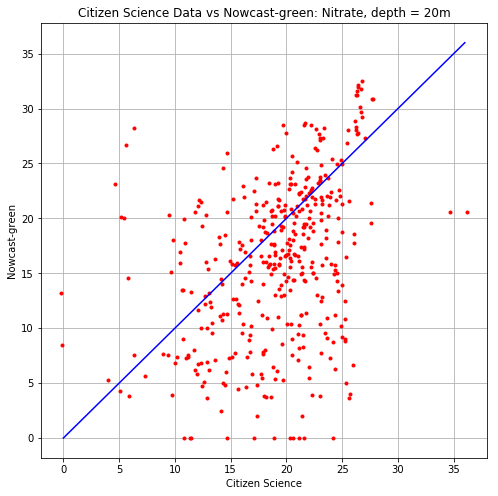

In [28]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(deeper_ni_cs, deeper_ni_model, 'r.')
ax.plot(np.arange(0,37), np.arange(0,37), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate, depth = 20m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(deeper_ni_cs) + np.mean(deeper_ni_model)))
print('RMSE = ' + str(np.sqrt(np.sum((deeper_ni_model - deeper_ni_cs)**2) /
                              len(deeper_ni_cs))))
xbar = np.mean(deeper_ni_cs)
print('Willmott = ' + str(1-(np.sum((deeper_ni_model - deeper_ni_cs)**2)  / 
                             np.sum((np.abs(deeper_ni_model - xbar) 
                                     + np.abs(deeper_ni_cs - xbar))**2))))

bias =  -12.0320383164
RMSE = 18.9518481956
Willmott = 0.690112733736


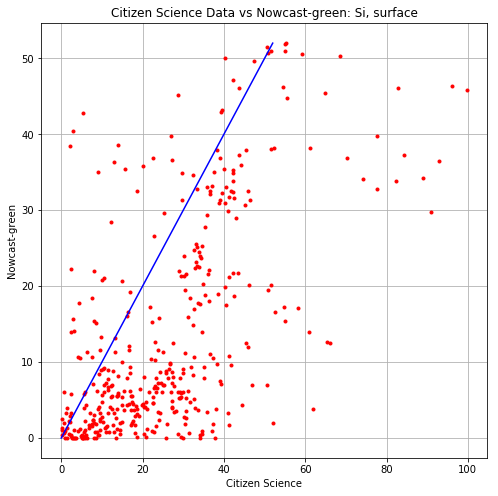

In [29]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(surface_si_cs, surface_si_model, 'r.')
ax.plot(np.arange(0,53), np.arange(0,53), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si, surface')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(surface_si_cs) + np.mean(surface_si_model)))
print('RMSE = ' + str(np.sqrt(np.sum((surface_si_model - surface_si_cs)**2) /
                              len(surface_si_cs))))
xbar = np.mean(surface_si_cs)
print('Willmott = ' + str(1-(np.sum((surface_si_model - surface_si_cs)**2)  / 
                             np.sum((np.abs(surface_si_model - xbar) 
                                     + np.abs(surface_si_cs - xbar))**2))))

bias =  -9.06080567556
RMSE = 15.9755459094
Willmott = 0.492747064708


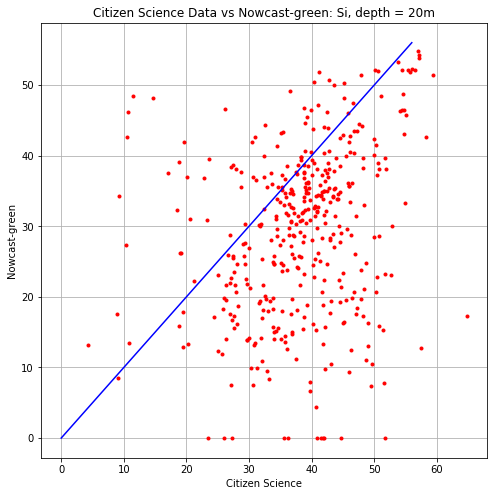

In [30]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(deeper_si_cs, deeper_si_model, 'r.')
ax.plot(np.arange(0,57), np.arange(0,57), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si, depth = 20m')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green')
print('bias =  ' + str(-np.mean(deeper_si_cs) + np.mean(deeper_si_model)))
print('RMSE = ' + str(np.sqrt(np.sum((deeper_si_model - deeper_si_cs)**2) /
                              len(deeper_si_cs))))
xbar = np.mean(deeper_si_cs)
print('Willmott = ' + str(1-(np.sum((deeper_si_model - deeper_si_cs)**2)  / 
                             np.sum((np.abs(deeper_si_model - xbar) 
                                     + np.abs(deeper_si_cs - xbar))**2))))

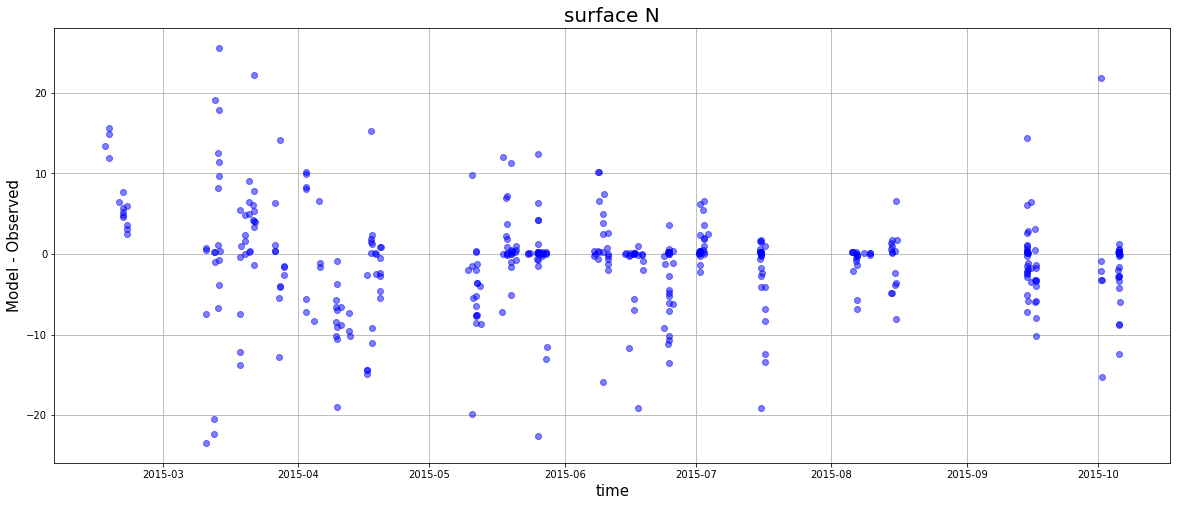

In [32]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_times, surface_ni_model - surface_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('surface N', fontsize = 20)

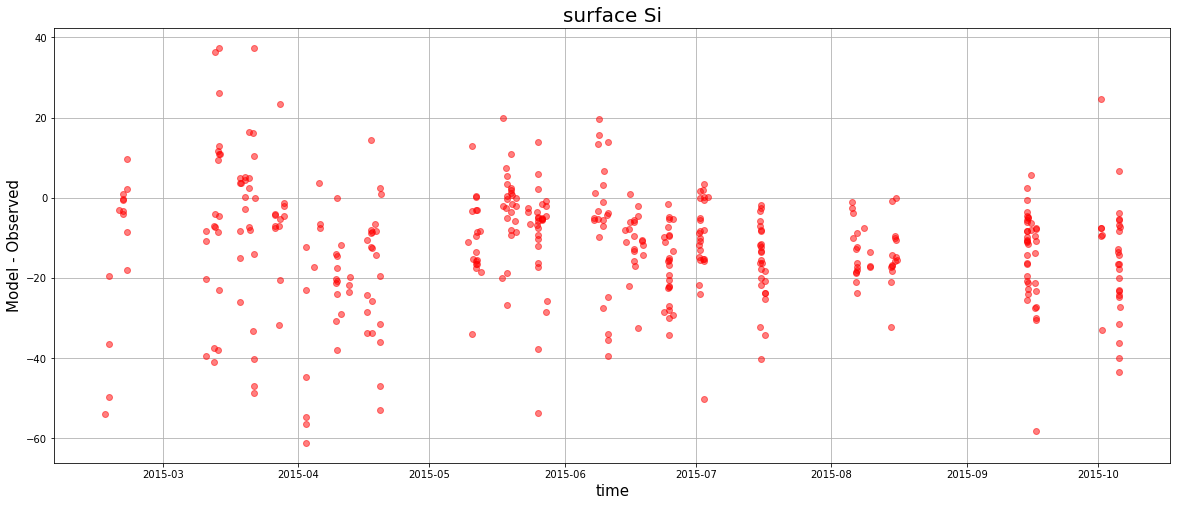

In [33]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_times, surface_si_model - surface_si_cs, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('surface Si', fontsize = 20)
ax.grid('on')

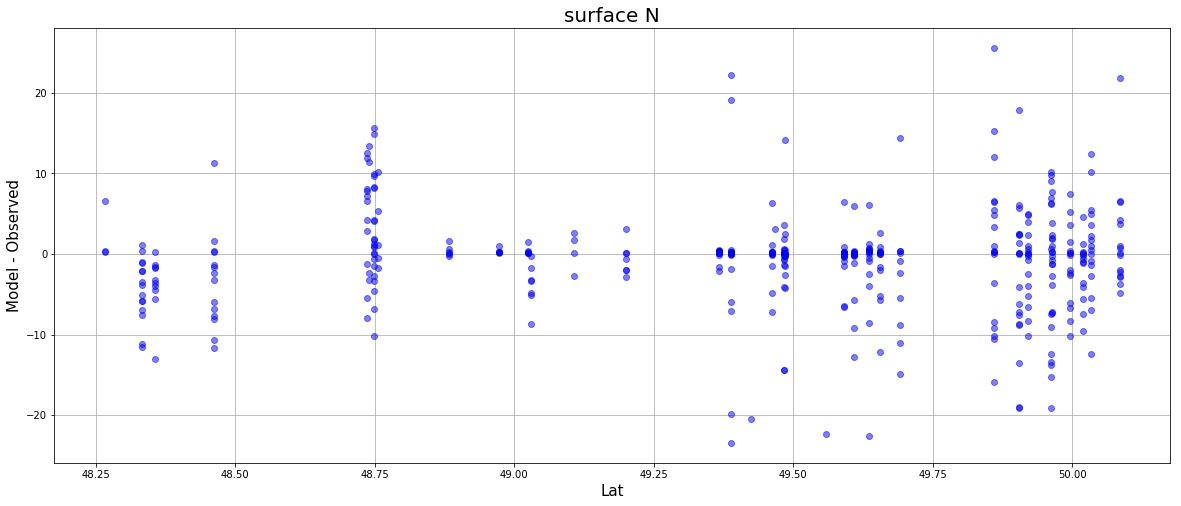

In [35]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_lats, surface_ni_model - surface_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('surface N', fontsize = 20)
ax.grid('on')

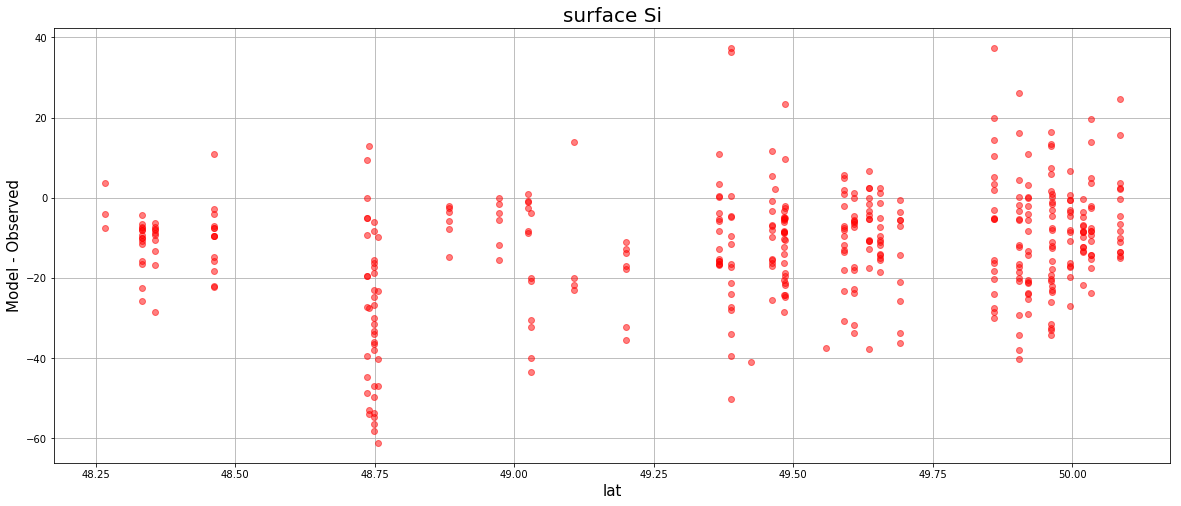

In [36]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(surface_lats, surface_si_model - surface_si_cs, 'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('surface Si', fontsize = 20)

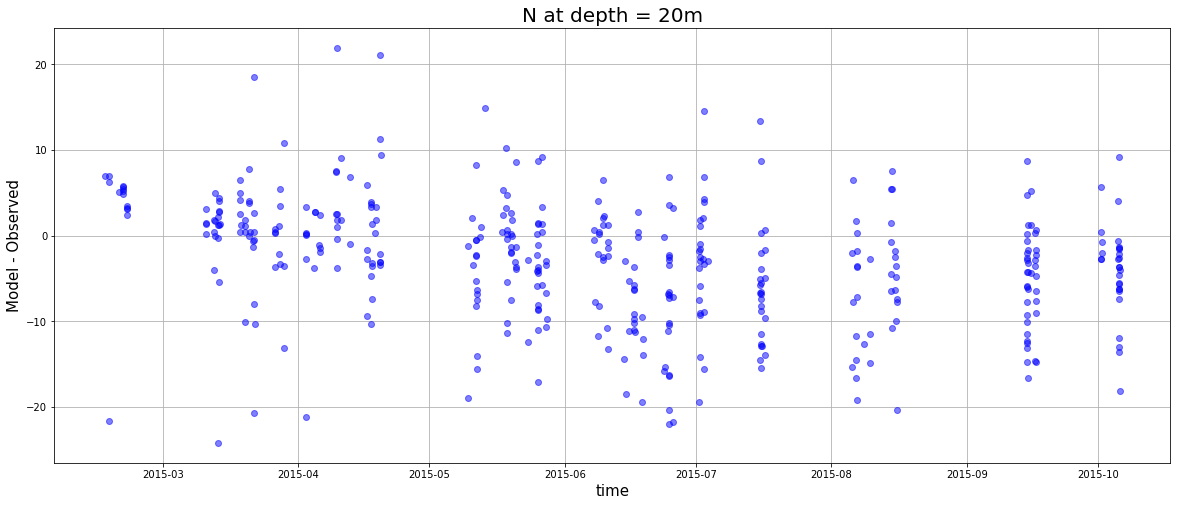

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_times, deeper_ni_model - deeper_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('N at depth = 20m', fontsize = 20)

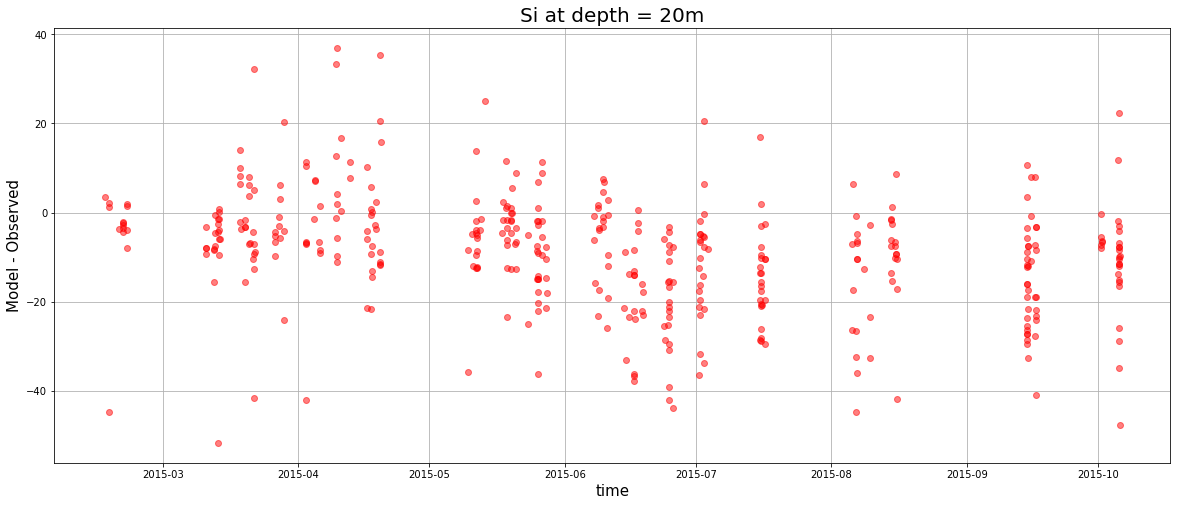

In [38]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_times, deeper_si_model - deeper_si_cs,'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si at depth = 20m', fontsize = 20)

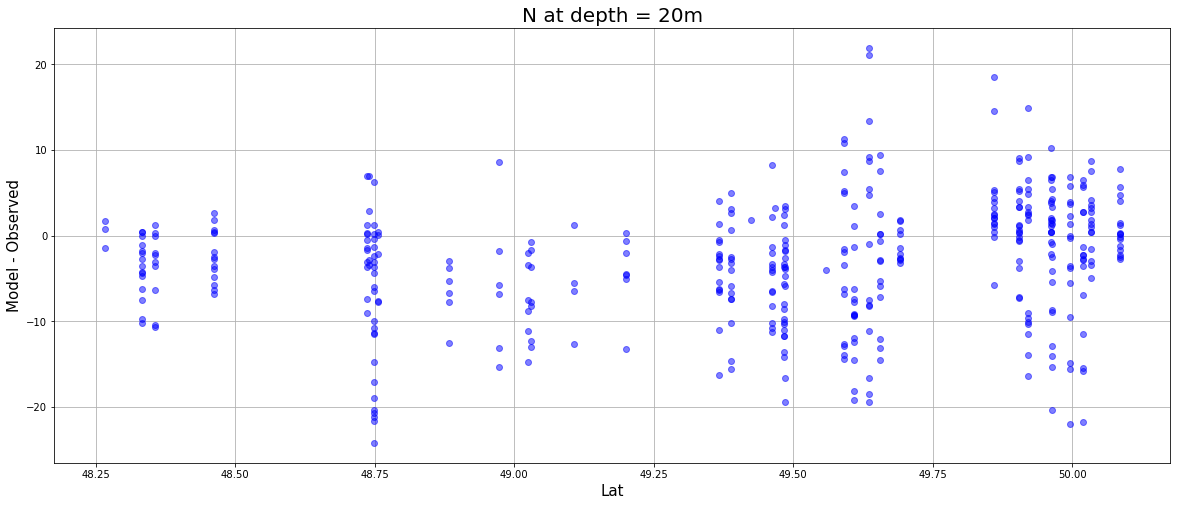

In [39]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_lats, deeper_ni_model - deeper_ni_cs,'bo', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('N at depth = 20m', fontsize = 20)

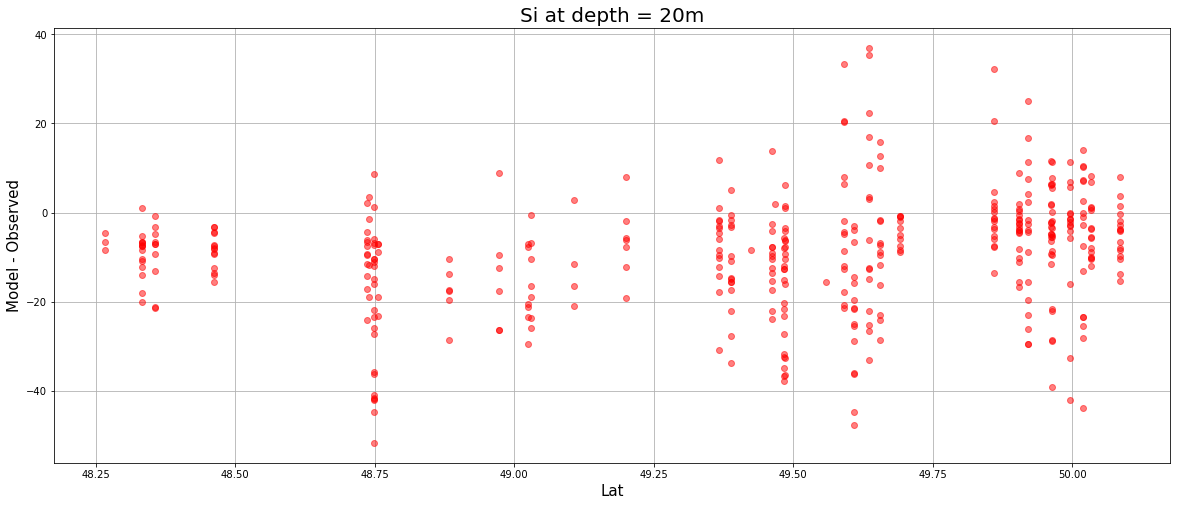

In [40]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(deeper_lats, deeper_si_model - deeper_si_cs,'ro', alpha =0.5)
ax.grid('on')
ax.set_xlabel('Lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si at depth = 20m', fontsize = 20)

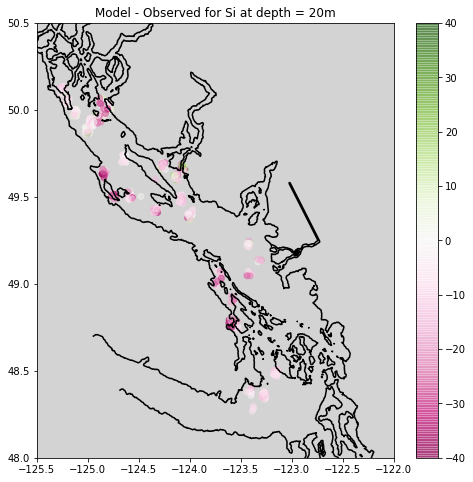

In [41]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((409))), 
                  deeper_lats + 0.05*np.random.random(size=((409))) , 
                  c = (deeper_si_model - deeper_si_cs), cmap = 'PiYG', alpha =0.5)
diff.set_clim([-40,40])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for Si at depth = 20m')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122)
ax.set_facecolor('lightgray')

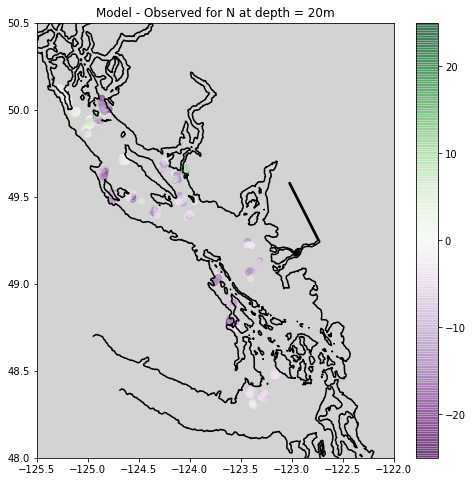

In [42]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((409))), 
                  deeper_lats + 0.05*np.random.random(size=((409))), 
                  c = (deeper_ni_model - deeper_ni_cs), cmap = 'PRGn', alpha = 0.5)
diff.set_clim([-25,25])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for N at depth = 20m')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);
ax.set_facecolor('lightgray')

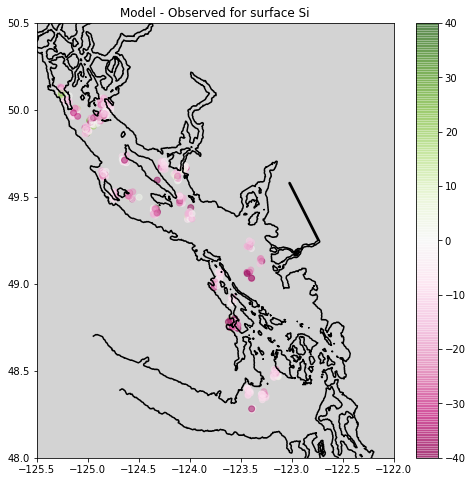

In [43]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((409))), 
                  deeper_lats + 0.05*np.random.random(size=((409))),
                  c = (surface_si_model - surface_si_cs), cmap = 'PiYG', alpha = 0.5)
diff.set_clim([-40,40])
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for surface Si')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);
ax.set_facecolor('lightgrey')

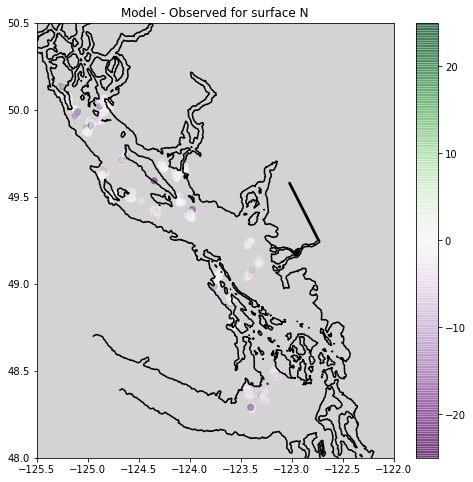

In [44]:
fig, ax = plt.subplots(figsize = (8,8))
diff = ax.scatter(deeper_lons + 0.05*np.random.random(size=((409))), 
                  deeper_lats + 0.05*np.random.random(size=((409))),
                  c = (surface_ni_model - surface_ni_cs), cmap = 'PRGn', 
                  vmin = -25, vmax =25, alpha=0.5)
viz_tools.plot_coastline(ax, grid, coords='map')
plt.colorbar(diff)
ax.set_title('Model - Observed for surface N')
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.5, -122);
ax.set_facecolor('lightgrey')

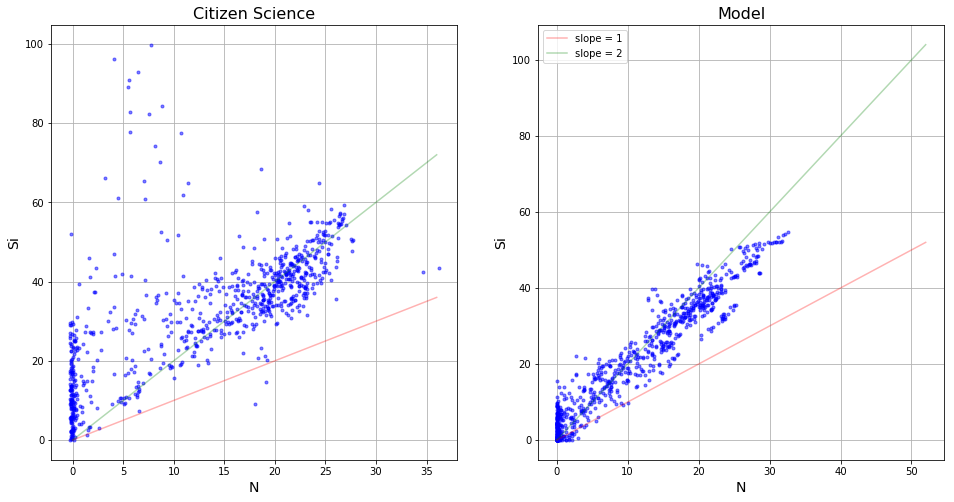

In [45]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(nutrients_2015['no23'].values, nutrients_2015['si'].values, 'b.', alpha = 0.5)
x = np.arange(0,37)
ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[1].plot(list_of_model_ni, list_of_model_si, 'b.', alpha = 0.5)
x = np.arange(0,53)
ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
plt.legend();